In [1]:
# Standard imports
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

# Third-party imports
import astropy.cosmology
from astropy import units as u
import hmf
import halomod

# Project imports
import pyhalomodel as halo
import pyhalomodel.utility as util
import pyhalomodel.camb_stuff as camb_stuff

/Users/Mead/Library/Caches/pypoetry/virtualenvs/pyhalomodel-9x4PpIM0-py3.10/lib/python3.10/site-packages/halomod/halo_exclusion.py:18: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  warnings.warn(


In [2]:
# Halo mass range [Msun/h]
Mmin, Mmax = 1e9, 1e17
nM = 256
M = util.logspace(Mmin, Mmax, nM)

# Wavenumbers [h/Mpc]
kmin, kmax = 1e-3, 1e1
nk = 256
k = util.logspace(kmin, kmax, nk)

# Set cosmological parameters
Omega_c = 0.25
Omega_b = 0.05
Omega_k = 0.0
h = 0.7
ns = 0.96
sigma_8  = 0.8

# Halo model
Dv = 200.
dc = 1.686

# Redshift
z = 0.

In [3]:
# Halomod

# Set cosmology
cosmodel = astropy.cosmology.Flatw0waCDM(
    H0 = 100.*h,
    Om0 = Omega_c+Omega_b, 
    Ob0 = Omega_b,
    w0 = -1.,
    Tcmb0 = 2.725*u.K, 
    Neff = 3.046,
    )

# Set trasfer function
transfmodel = {
    'sigma_8': sigma_8, 
    'n': ns,
    'lnk_min': np.log(kmin), 
    'lnk_max': np.log(kmax), 
    'dlnk': np.log(kmax/kmin)/nk
    }

# Setup halomod
hmod = halomod.HaloModel(
    Mmin = np.log10(Mmin),
    Mmax = np.log10(Mmax),
    dlog10m = np.log10(Mmax/Mmin)/nM,
    #hmf_model = hmf.mass_function.fitting_functions.Tinker10,
    hmf_model = hmf.mass_function.fitting_functions.ST,
    #mdef_model = 'SOMean',
    mdef_model = 'SOVirial',
    #mdef_params = {'overdensity': Dv},
    disable_mass_conversion = True,
    delta_c = dc,
    cosmo_model = cosmodel,
    z = z,
    transfer_model = hmf.density_field.transfer_models.CAMB,
    halo_profile_model = 'NFW',
    halo_concentration_model = 'Duffy08',
    halo_concentration_params = {'sample': 'full'},
    force_1halo_turnover = False,
    **transfmodel,
    )

In [4]:
#hmod.get_all_parameter_defaults()
hmod.parameter_values

{'bias_model': halomod.bias.Tinker10,
 'bias_params': {},
 'cosmo_model': Flatw0waCDM(H0=70.0 km / (Mpc s), Om0=0.3, w0=-1.0, wa=0.0, Tcmb0=2.725 K, Neff=3.046, m_nu=[0. 0. 0.] eV, Ob0=0.05),
 'cosmo_params': {},
 'n': 0.96,
 'sigma_8': 0.8,
 'growth_params': {},
 'lnk_min': -6.907755278982137,
 'lnk_max': 2.302585092994046,
 'dlnk': 0.03597789207803197,
 'z': 0.0,
 'transfer_model': hmf.density_field.transfer_models.CAMB,
 'transfer_params': {},
 'takahashi': True,
 'growth_model': hmf.cosmology.growth_factor.CambGrowth,
 'hmf_model': hmf.mass_function.fitting_functions.ST,
 'Mmin': 9.0,
 'Mmax': 17.0,
 'dlog10m': 0.03125,
 'mdef_model': hmf.halos.mass_definitions.SOVirial,
 'mdef_params': {},
 'delta_c': 1.686,
 'hmf_params': {},
 'filter_model': hmf.density_field.filters.TopHat,
 'filter_params': {},
 'disable_mass_conversion': True,
 'halo_profile_model': halomod.profiles.NFW,
 'halo_profile_params': {},
 'halo_concentration_model': halomod.concentration.Duffy08,
 'halo_concentrati

In [5]:
# pyhalomodel
use_CAMB = False

# CAMB stuff
if use_CAMB:
    Pk_lin, camb_results, Omega_m, _, _ = camb_stuff.run([z], Omega_c, Omega_b, Omega_k, h, ns, sigma_8)
    Pk_lin = Pk_lin(z, k)
else:
    Omega_m = Omega_c+Omega_b
    Pk_lin = hmod.linear_power_fnc(k)

# Halo model
#pyhmod = halo.model(z, Omega_m, name='Tinker et al. (2010)', Dv=Dv, dc=dc)
pyhmod = halo.model(z, Omega_m, name='Sheth & Tormen (1999)', Dv=Dv, dc=dc)
if use_CAMB:
    R = pyhmod.Lagrangian_radius(M)
    sigmaM = camb_results.get_sigmaR(R, hubble_units=True, return_R_z=False)[[z].index(z)]
else:
    sigmaM = hmod.sigma

# Halo profiles
rv = pyhmod.virial_radius(M)
c = halo.concentration(M, z, method='Duffy et al. (2008)')
matter_profile = halo.matter_profile(k, M, rv, c, pyhmod.Om_m)

# Power
Pk_2h, Pk_1h, Pk_hm = pyhmod.power_spectrum(k, Pk_lin, M, sigmaM, {'m': matter_profile})

/Users/Mead/Library/Caches/pypoetry/virtualenvs/pyhalomodel-9x4PpIM0-py3.10/lib/python3.10/site-packages/halomod/tools.py:653: UserWarning: You are using an un-normalized mass function and bias function pair.Bias Tinker10 has the following paired HMF model: (). Matter correlations are not well-defined.
  warnings.warn(
/Users/Mead/Library/Caches/pypoetry/virtualenvs/pyhalomodel-9x4PpIM0-py3.10/lib/python3.10/site-packages/hmf/density_field/halofit.py:107: UserWarning: sigma_8 is not used any more, and will be removed in v4
  warnings.warn("sigma_8 is not used any more, and will be removed in v4")


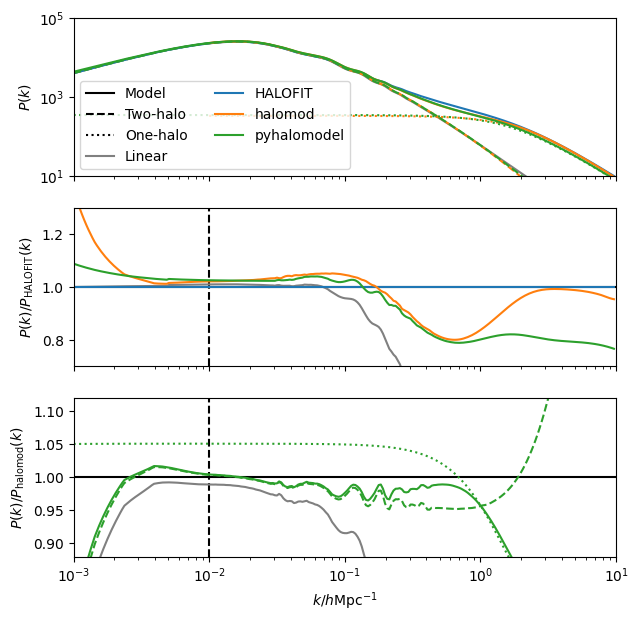

In [6]:
# Initialise
plt.subplots(3, 1, sharex=True, figsize=(7, 7))
Pkmin, Pkmax = 1e1, 1e5
rmin, rmax = 0.7, 1.3
smin, smax = 0.88, 1.12
logPk_hm_halomod = interpolate.interp1d(np.log(hmod.k_hm), np.log(hmod.power_auto_matter), kind='cubic', fill_value='extrapolate', bounds_error=None)
logPk_2h_halomod = interpolate.interp1d(np.log(hmod.k_hm), np.log(hmod.power_2h_auto_matter), kind='cubic', fill_value='extrapolate', bounds_error=None)
logPk_1h_halomod = interpolate.interp1d(np.log(hmod.k_hm), np.log(hmod.power_1h_auto_matter), kind='cubic', fill_value='extrapolate', bounds_error=None)

# Power
plt.subplot(3, 1, 1)
plt.plot(np.nan, color='black', ls='-', label='Model')
plt.plot(np.nan, color='black', ls='--', label='Two-halo')
plt.plot(np.nan, color='black', ls=':', label='One-halo')
plt.loglog(hmod.k, Pk_lin, color='grey', label='Linear')
plt.loglog(hmod.k, hmod.nonlinear_power, label='HALOFIT', color='C0')
plt.loglog(hmod.k_hm, hmod.power_auto_matter, label='halomod', color='C1')
plt.loglog(hmod.k_hm, hmod.power_2h_auto_matter, ls='--', color='C1')
plt.loglog(hmod.k_hm, hmod.power_1h_auto_matter, ls=':', color='C1')
plt.loglog(k, Pk_hm['m-m'], label='pyhalomodel', color='C2')
plt.loglog(k, Pk_2h['m-m'], ls='--', color='C2')
plt.loglog(k, Pk_1h['m-m'], ls=':', color='C2')
plt.xticks([])
plt.ylabel('$P(k)$')
plt.ylim((Pkmin, Pkmax))
plt.legend(loc='lower left', ncol=2)

# Ratio with HALOFIT
plt.subplot(3, 1, 2)
plt.axhline(1., color='black')
plt.axvline(hmod.k_hm[0], color='black', ls='--')
plt.axvline(hmod.k_hm[-1], color='black', ls='--')
plt.semilogx(hmod.k, Pk_lin/hmod.nonlinear_power, color='grey')
plt.semilogx(hmod.k, hmod.nonlinear_power/hmod.nonlinear_power, color='C0')
plt.semilogx(hmod.k, np.exp(logPk_hm_halomod(np.log(hmod.k)))/hmod.nonlinear_power, color='C1')
plt.semilogx(hmod.k, Pk_hm['m-m']/hmod.nonlinear_power, color='C2')
plt.xticks([])
plt.xlim((kmin, kmax))
plt.ylabel('$P(k)/P_\mathrm{HALOFIT}(k)$')
plt.ylim((rmin, rmax))

# Ratio with halomod
plt.subplot(3, 1, 3)
plt.axhline(1., color='black')
plt.axvline(hmod.k_hm[0], color='black', ls='--')
plt.axvline(hmod.k_hm[-1], color='black', ls='--')
plt.semilogx(hmod.k, Pk_lin/np.exp(logPk_hm_halomod(np.log(hmod.k))), ls='-', color='grey')
plt.semilogx(hmod.k, Pk_hm['m-m']/np.exp(logPk_hm_halomod(np.log(hmod.k))), ls='-', color='C2')
plt.semilogx(hmod.k, Pk_2h['m-m']/np.exp(logPk_2h_halomod(np.log(hmod.k))), ls='--', color='C2')
plt.semilogx(hmod.k, Pk_1h['m-m']/np.exp(logPk_1h_halomod(np.log(hmod.k))), ls=':', color='C2')
plt.xlabel('$k/h\mathrm{Mpc}^{-1}$')
plt.xlim((kmin, kmax))
plt.ylabel('$P(k)/P_\mathrm{halomod}(k)$')
plt.ylim((smin, smax))

# Finalise
plt.show()